<a href="https://colab.research.google.com/github/Nandusasikumar1/Youtube-title-classification/blob/main/youtube_title_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Youtube title classification using NLP and Random forests algorithm.
 * Used `Youtube Data Api v3` for collecting the data.
 
 * Collected titles for 4 search queries:  **Machine learning,Maths,Smat phone,food** (16500 titles in each title category).

 * Used this data for training Random forests classifier and created a Youtube title category classification model.

* If we give title of a youtube video title as input to the model,It will output the category of the title.

* Since the *Youtube Data Api* has requests limits ,I used multiple google accounts for creating different api keys and retrieved data .(It took 3 days)



Data collection

In [ ]:
#  # I used local machine for running this data collection code you can do this in colab also
# from googleapiclient.discovery import build #import  googleapliclient library for creating api requests
# import json
# import time

# YOUTUBE_API_SERVICE_NAME = "youtube"
# YOUTUBE_API_VERSION = "v3"

# import json 
# with open('/content/secrets.json','r') as secrets:
#   keys = json.load(secrets)

# def get_data(search_query:str,folder:str): #Function for creating a an api requests and store the results in a folder as json file
#     youtube=build(developerKey=keys['key1'],serviceName=YOUTUBE_API_SERVICE_NAME,version=YOUTUBE_API_VERSION) #Create build instance and pass the search query ,api key ,max results and language
#     search_keyword = youtube.search().list(q = search_query, part = "snippet",
#                                                 maxResults = 50,relevanceLanguage='en').execute() #execute request

#     data=[(i['snippet']['title'],i['snippet']['description']) for i in search_keyword['items']] #collecting title and description of different videos for a particular search query
#     page_token=search_keyword['nextPageToken'] 

#     """youtube data api has certain limitations.We need to find the next page token in each request and should pass it to the next request for fetching the next 50 results
#     (the maximum number of results in one request response is 50 and we will only get a maximum of 10 iterations .That's why I used 10 in the range function in for loop.The for loop 
#     is used for fetching the next 50 results in each request with different page tokens)
#      """

#     for i in range(10):
#         # time.sleep(10)
#         search_keyword = youtube.search().list(q = search_query, part = "snippet",
#                                                 maxResults = 100,pageToken=page_token,relevanceLanguage='en')\
#                                                     .execute()
    
#         data.extend([(i['snippet']['title'],i['snippet']['description']) for i in search_keyword['items']])
#         page_token=search_keyword['nextPageToken']
#         print(page_token)
    
#     with open(f"{folder}/{search_query}.json", "w",encoding='utf8') as outfile:# saving the collected data as a json file with the name of the search query in the specified folder
#         json.dump(data, outfile,ensure_ascii=False,indent=2)

# get_data('vivo smartphones','smart phone')

Importing required packages
* os for locating file paths
* pandas for creating Data Frame
* Seaborn and Matplotlib for visualsation
* nltk for Natural language Processing(word lemmatization,removing stop words etc..)
* sklearn for building our machine learning model

In [1]:
import os
import pandas as pd
import json

import seaborn as sns
import matplotlib .pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier


### Loading data from google drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Using os for accessing the files in drive and creating a Data Frame with pandas

In [ ]:
root_dir='youtube_analysis'
folders=[i for i in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir,i))]
df=pd.DataFrame(columns=['title','category'])
for folder in folders:
  for file in os.listdir(os.path.join(root_dir,folder)):
    with open(os.path.join(root_dir,folder,file)) as f:
      data=json.load(f)
      temp_df=pd.DataFrame([[d[0],folder] for d in data],columns=['title','category'])
      df=pd.concat([df,temp_df],ignore_index=True)
        
    


In [ ]:
df

,title,category
0,Kolkata&#39;s Famous Egg Ghugni at Railway Sta...,food
1,Eating Triangle Food for a day || Triangle Foo...,food
2,Indian Tries Authentic Singapore Restaurant Fo...,food
3,I Tried India’s Most Weird Street Food 😱 *MAGG...,food
4,INDIAN FOOD MAGIC | CARRYMINATI,food
...,...,...
65995,Vivo T1 Unboxing #youtubeshorts #ytshorts #sho...,smart phone
65996,Upcoming SmartPhones In April 2022 ⭐,smart phone
65997,How to 🔓Unlock Bootloader on any Vivo smartpho...,smart phone
65998,Vivo T1. #shorts #video #trending #viral #...,smart phone


### Visualizing the Count of titles in each category using seaborn

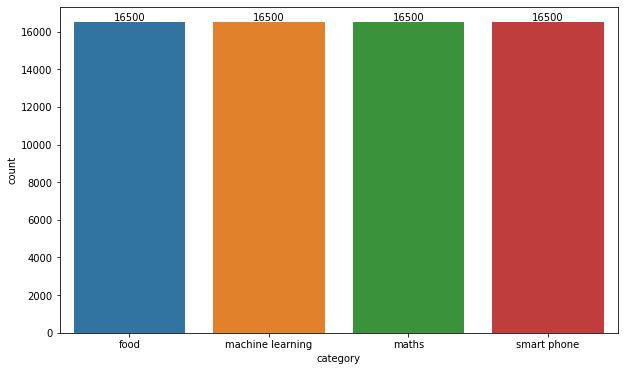

In [ ]:
plt.figure(figsize=(10,6))
plot=sns.countplot(data=df,x='category')
plt.bar_label(plot.containers[0])
plt.show()

### Checking if there are any null values in the data

In [ ]:
df.isna().sum()

title       0
category    0
dtype: int64

### Removing special characters in the titles using regex

In [ ]:
df['title']=df['title'].str.replace('[^a-zA-Z0-9]+',' ',regex=True)

In [ ]:
df

,title,category
0,Kolkata 39 s Famous Egg Ghugni at Railway Stat...,food
1,Eating Triangle Food for a day Triangle Food C...,food
2,Indian Tries Authentic Singapore Restaurant Fo...,food
3,I Tried India s Most Weird Street Food MAGGI D...,food
4,INDIAN FOOD MAGIC CARRYMINATI,food
...,...,...
65995,Vivo T1 Unboxing youtubeshorts ytshorts shorts...,smart phone
65996,Upcoming SmartPhones In April 2022,smart phone
65997,How to Unlock Bootloader on any Vivo smartphon...,smart phone
65998,Vivo T1 shorts video trending viral subscribe ...,smart phone


In [ ]:
nltk.download('stopwords')
stop=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenizing the titles using nltk.word_tokenize method

In [ ]:
nltk.download('punkt')
df['title'] = df['title'].apply(lambda x: [i.lower() for i in nltk.word_tokenize(x) if i.lower() not in stop])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df

,title,category
0,"[kolkata, 39, famous, egg, ghugni, railway, st...",food
1,"[eating, triangle, food, day, triangle, food, ...",food
2,"[indian, tries, authentic, singapore, restaura...",food
3,"[tried, india, weird, street, food, maggi, dosa]",food
4,"[indian, food, magic, carryminati]",food
...,...,...
65995,"[vivo, t1, unboxing, youtubeshorts, ytshorts, ...",smart phone
65996,"[upcoming, smartphones, april, 2022]",smart phone
65997,"[unlock, bootloader, vivo, smartphones, lock, ...",smart phone
65998,"[vivo, t1, shorts, video, trending, viral, sub...",smart phone


In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Lemmatizing the words in each title to convert each word to its root form

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['title'] = df['title'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x]).apply(lambda x:' '.join(x))

In [ ]:
df

,title,category
0,kolkata 39 famous egg ghugni railway station i...,food
1,eating triangle food day triangle food challen...,food
2,indian try authentic singapore restaurant food...,food
3,tried india weird street food maggi dosa,food
4,indian food magic carryminati,food
...,...,...
65995,vivo t1 unboxing youtubeshorts ytshorts short ...,smart phone
65996,upcoming smartphones april 2022,smart phone
65997,unlock bootloader vivo smartphones lock bootlo...,smart phone
65998,vivo t1 short video trending viral subscribe i...,smart phone


### splitting the data into train and test sets for training the model and performance evaluation of the model

In [ ]:
x=df.iloc[:,0:-1].values
y=df.iloc[:,-1].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.1,random_state=1,stratify=y)


In [ ]:
x

array([['kolkata 39 famous egg ghugni railway station indian street food'],
       ['eating triangle food day triangle food challenge 24 hour'],
       ['indian try authentic singapore restaurant food saute short'],
       ...,
       ['unlock bootloader vivo smartphones lock bootloader'],
       ['vivo t1 short video trending viral subscribe instagram short shortvideo reel'],
       ['vivo smartphone blacklist solution short viral video']],
      dtype=object)

In [ ]:
y

array(['food', 'food', 'food', ..., 'smart phone', 'smart phone',
       'smart phone'], dtype=object)

### Creating a pipeline for Tfidfvectorizer(for vectorizing the title) and Randomforests algorithm

In [ ]:
clf=Pipeline([('tfidf',TfidfVectorizer()),('classifer',RandomForestClassifier())])


### Training Random forests using training data

In [ ]:
clf.fit(x_train.flatten(),y_train.flatten())

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifer', RandomForestClassifier())])

### Testing test data and make predicitons for performance evaluation of the model

In [ ]:
y_pred=clf.predict(x_test.flatten())

In [ ]:
y_pred

array(['maths', 'maths', 'smart phone', ..., 'smart phone', 'smart phone',
       'food'], dtype=object)

### Use classification report for calculating the perfomance metrics such as precision ,recall ,accuracy and f1 score

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
report=classification_report(y_test,y_pred)

In [ ]:
print(report)

                  precision    recall  f1-score   support

            food       0.98      1.00      0.99      1650
machine learning       0.99      0.99      0.99      1650
           maths       0.99      0.97      0.98      1650
     smart phone       1.00      1.00      1.00      1650

        accuracy                           0.99      6600
       macro avg       0.99      0.99      0.99      6600
    weighted avg       0.99      0.99      0.99      6600



### Predicting the category of new titles

In [ ]:
clf.predict([""" feature selection techniques """])

array(['machine learning'], dtype=object)

In [ ]:
clf.predict(['Kerala egg curry recipe'])

array(['food'], dtype=object)

In [ ]:
clf.predict(['Linear algebra tutorial'])

array(['maths'], dtype=object)

In [ ]:
clf.predict(['amoled vs oled display'])

array(['smart phone'], dtype=object)